In [33]:
from rich.logging import RichHandler
import logging
from lightning_lite.utilities.seed import seed_everything
from shell_data.dataset.dataset import get_train_val_test_subsets
import torch
import os
from shell_data.utils.config import (
    ShELLDataSharingConfig,
    DatasetConfig,
    TaskModelConfig,
    TrainingConfig,
)
from shell_data.shell_agent.shell_agent_classification import ShELLClassificationAgent

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import umap
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
torch.use_deterministic_algorithms(True)
seed_everything(0)

Global seed set to 0


0

In [34]:
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [35]:
from torchvision.models import resnet18, alexnet, vgg11_bn, squeezenet1_0, densenet121, inception_v3
backbone = resnet18(pretrained=True)

/home/vlongle/miniconda3/envs/data-sharing/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vlongle/miniconda3/envs/data-sharing/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
# import torch.nn as nn
# def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
#     """3x3 convolution with padding"""
#     return nn.Conv2d(
#         in_planes,
#         out_planes,
#         kernel_size=3,
#         stride=stride,
#         padding=dilation,
#         groups=groups,
#         bias=False,
#         dilation=dilation,
#     )


# def conv1x1(in_planes, out_planes, stride=1):
#     """1x1 convolution"""
#     return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(
#         self,
#         inplanes,
#         planes,
#         stride=1,
#         downsample=None,
#         groups=1,
#         base_width=64,
#         dilation=1,
#         norm_layer=None,
#     ):
#         super(BasicBlock, self).__init__()
#         if norm_layer is None:
#             norm_layer = nn.BatchNorm2d
#         if groups != 1 or base_width != 64:
#             raise ValueError("BasicBlock only supports groups=1 and base_width=64")
#         if dilation > 1:
#             raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
#         # Both self.conv1 and self.downsample layers downsample the input when stride != 1
#         self.conv1 = conv3x3(inplanes, planes, stride)
#         self.bn1 = norm_layer(planes)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = conv3x3(planes, planes)
#         self.bn2 = norm_layer(planes)
#         self.downsample = downsample
#         self.stride = stride

#     def forward(self, x):
#         identity = x

#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)

#         out = self.conv2(out)
#         out = self.bn2(out)

#         if self.downsample is not None:
#             identity = self.downsample(x)

#         out += identity
#         out = self.relu(out)

#         return out


# class Bottleneck(nn.Module):
#     expansion = 4

#     def __init__(
#         self,
#         inplanes,
#         planes,
#         stride=1,
#         downsample=None,
#         groups=1,
#         base_width=64,
#         dilation=1,
#         norm_layer=None,
#     ):
#         super(Bottleneck, self).__init__()
#         if norm_layer is None:
#             norm_layer = nn.BatchNorm2d
#         width = int(planes * (base_width / 64.0)) * groups
#         # Both self.conv2 and self.downsample layers downsample the input when stride != 1
#         self.conv1 = conv1x1(inplanes, width)
#         self.bn1 = norm_layer(width)
#         self.conv2 = conv3x3(width, width, stride, groups, dilation)
#         self.bn2 = norm_layer(width)
#         self.conv3 = conv1x1(width, planes * self.expansion)
#         self.bn3 = norm_layer(planes * self.expansion)
#         self.relu = nn.ReLU(inplace=True)
#         self.downsample = downsample
#         self.stride = stride

#     def forward(self, x):
#         identity = x

#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)

#         out = self.conv2(out)
#         out = self.bn2(out)
#         out = self.relu(out)

#         out = self.conv3(out)
#         out = self.bn3(out)

#         if self.downsample is not None:
#             identity = self.downsample(x)

#         out += identity
#         out = self.relu(out)

#         return out


# class ResNet(nn.Module):
#     def __init__(
#         self,
#         block,
#         layers,
#         num_classes=10,
#         zero_init_residual=False,
#         groups=1,
#         width_per_group=64,
#         replace_stride_with_dilation=None,
#         norm_layer=None,
#     ):
#         super(ResNet, self).__init__()
#         if norm_layer is None:
#             norm_layer = nn.BatchNorm2d
#         self._norm_layer = norm_layer

#         self.inplanes = 64
#         self.dilation = 1
#         if replace_stride_with_dilation is None:
#             # each element in the tuple indicates if we should replace
#             # the 2x2 stride with a dilated convolution instead
#             replace_stride_with_dilation = [False, False, False]
#         if len(replace_stride_with_dilation) != 3:
#             raise ValueError(
#                 "replace_stride_with_dilation should be None "
#                 "or a 3-element tuple, got {}".format(replace_stride_with_dilation)
#             )
#         self.groups = groups
#         self.base_width = width_per_group

#         # CIFAR10: kernel_size 7 -> 3, stride 2 -> 1, padding 3->1
#         self.conv1 = nn.Conv2d(
#             3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False
#         )
#         # END

#         self.bn1 = norm_layer(self.inplanes)
#         self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#         self.layer1 = self._make_layer(block, 64, layers[0])
#         self.layer2 = self._make_layer(
#             block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0]
#         )
#         self.layer3 = self._make_layer(
#             block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1]
#         )
#         self.layer4 = self._make_layer(
#             block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2]
#         )
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512 * block.expansion, num_classes)

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
#             elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

#         # Zero-initialize the last BN in each residual branch,
#         # so that the residual branch starts with zeros, and each residual block behaves like an identity.
#         # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
#         if zero_init_residual:
#             for m in self.modules():
#                 if isinstance(m, Bottleneck):
#                     nn.init.constant_(m.bn3.weight, 0)
#                 elif isinstance(m, BasicBlock):
#                     nn.init.constant_(m.bn2.weight, 0)

#     def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
#         norm_layer = self._norm_layer
#         downsample = None
#         previous_dilation = self.dilation
#         if dilate:
#             self.dilation *= stride
#             stride = 1
#         if stride != 1 or self.inplanes != planes * block.expansion:
#             downsample = nn.Sequential(
#                 conv1x1(self.inplanes, planes * block.expansion, stride),
#                 norm_layer(planes * block.expansion),
#             )

#         layers = []
#         layers.append(
#             block(
#                 self.inplanes,
#                 planes,
#                 stride,
#                 downsample,
#                 self.groups,
#                 self.base_width,
#                 previous_dilation,
#                 norm_layer,
#             )
#         )
#         self.inplanes = planes * block.expansion
#         for _ in range(1, blocks):
#             layers.append(
#                 block(
#                     self.inplanes,
#                     planes,
#                     groups=self.groups,
#                     base_width=self.base_width,
#                     dilation=self.dilation,
#                     norm_layer=norm_layer,
#                 )
#             )

#         return nn.Sequential(*layers)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.avgpool(x)
#         x = x.reshape(x.size(0), -1)
#         x = self.fc(x)

#         return x


# def _resnet(arch, block, layers, pretrained, progress, device, **kwargs):
#     model = ResNet(block, layers, **kwargs)
#     return model


# def resnet18(pretrained=False, progress=True, device="cpu", **kwargs):
#     """Constructs a ResNet-18 model.
#     Args:
#         pretrained (bool): If True, returns a model pre-trained on ImageNet
#         progress (bool): If True, displays a progress bar of the download to stderr
#     """
#     return _resnet(
#         "resnet18", BasicBlock, [2, 2, 2, 2], pretrained, progress, device, **kwargs
#     )

In [37]:
# # load the model (pretrained on cifar10 https://github.com/huyvnphan/PyTorch_CIFAR10)
# backbone = resnet18(pretrained=True, progress=False, device="cpu")
# backbone.load_state_dict(torch.load('resnet18.pt'))

In [38]:
backbone

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [39]:
# get everything before the fc layer
# backbone.layer4[1].bn2.register_forward_hook(get_features('feats'))
# backbone.layer4[1].bn2.register_forward_hook(get_features('feats'))

In [40]:
backbone.avgpool.register_forward_hook(get_features('feats'))

In [41]:
# # import resnet18 pretrained on imagenet
# from torchvision.models import resnet18, alexnet, vgg11_bn, squeezenet1_0, densenet121, inception_v3
# from torchvision import transforms

# model_name = "resnet18"
# if model_name == "resnet18":
#     backbone = resnet18(pretrained=True)
# elif model_name == "alexnet":
#     backbone = alexnet(pretrained=True)
# elif model_name == "vgg11_bn":
#     backbone = vgg11_bn(pretrained=True)
# elif model_name == "squeezenet1_0":
#     backbone = squeezenet1_0(pretrained=True)
# elif model_name == "densenet121":
#     backbone = densenet121(pretrained=True)
# elif model_name == "inception_v3":
#     backbone = inception_v3(pretrained=True)

In [42]:
# X.shape (batch_size, 3, 32, 32) from cifar10
def cifar10_to_backbone_embedding(model, X):
    with torch.no_grad():
        return model(X)

In [43]:
def to_features(X):
    return X.view(X.size(0), -1)

def dist(X, X2, p=2):
    return torch.cdist(to_features(X), to_features(X2), p=p)

In [44]:
def get_xy(dataset):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))
    return next(iter(dataloader))

In [45]:
dataset_name = "cifar10"
train_subsets, val_subsets, test_subsets = get_train_val_test_subsets(
    dataset_name)
size = 128
num_cls_per_task = 2

cfg = ShELLDataSharingConfig(
    n_agents=1,
    dataset=DatasetConfig(
        name=dataset_name,
        train_size=size,
        val_size=min(size, min([len(d) for d in val_subsets])),
        num_task_per_life=1,
        num_cls_per_task=num_cls_per_task,
    ),
    task_model=TaskModelConfig(
        name=dataset_name,
    ),
    training=TrainingConfig(
        n_epochs=100,
    )
)

Files already downloaded and verified
Files already downloaded and verified


In [46]:
sender = ShELLClassificationAgent(
        train_subsets, val_subsets, test_subsets, cfg,
        enable_validate_config=False,)

receiver = ShELLClassificationAgent(
        train_subsets, val_subsets, test_subsets, cfg,
        enable_validate_config=False,)

sender.ll_dataset.perm = torch.tensor([5, 1])  # should send 5
receiver.ll_dataset.perm = torch.tensor([7, 5]) 

In [47]:
sender_data = sender.ll_dataset.get_train_dataset(0)
receiver_data = receiver.ll_dataset.get_train_dataset(0)

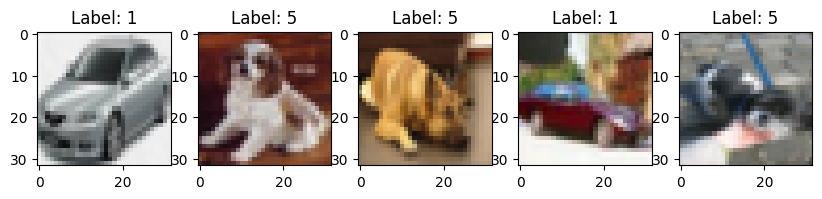

In [48]:
# plot some random images from sender_data
n_samples = 5
fig, ax = plt.subplots(1, n_samples, figsize=(10, 10))
for i in range(n_samples):
    random_idx = np.random.randint(0, len(sender_data))
    ax[i].imshow(sender_data[random_idx][0].permute(1, 2, 0))
    ax[i].set_title(f"Label: {sender_data[random_idx][1]}")
plt.show()

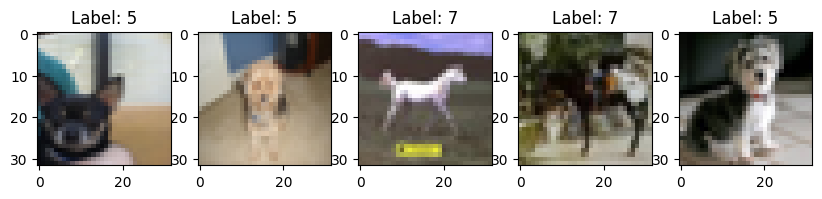

In [49]:
# plot some random images from receiver_data
n_samples = 5
fig, ax = plt.subplots(1, n_samples, figsize=(10, 10))
for i in range(n_samples):
    random_idx = np.random.randint(0, len(sender_data))
    ax[i].imshow(receiver_data[random_idx][0].permute(1, 2, 0))
    ax[i].set_title(f"Label: {receiver_data[random_idx][1]}")
plt.show()

In [50]:
receiver_x, receiver_y = get_xy(receiver_data)
sender_x, sender_y = get_xy(sender_data)

In [51]:
# receiver_x = cifar10_to_backbone_embedding(receiver_x)['feats']
# receiver_x = cifar10_to_backbone_embedding(receiver_x)['feats']
# features = {}
# sender_x = cifar10_to_backbone_embedding(sender_x)['feats']
features = {}
cifar10_to_backbone_embedding(receiver_x)
receiver_x = features['feats']
features = {}
cifar10_to_backbone_embedding(sender_x)
sender_x = features['feats']
print("shape:", receiver_x.shape, sender_x.shape)

shape: torch.Size([256, 512, 1, 1]) torch.Size([256, 512, 1, 1])


In [52]:
receiver_x = to_features(receiver_x)
sender_x = to_features(sender_x)
print("shape:", receiver_x.shape, sender_x.shape)

shape: torch.Size([256, 512]) torch.Size([256, 512])


In [53]:
joint_x = torch.cat([receiver_x, sender_x])
joint_y = torch.cat([receiver_y, sender_y])

In [56]:
n_neighbors = 15
reducer = umap.UMAP(n_neighbors=n_neighbors)
reducer.fit(joint_x)

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

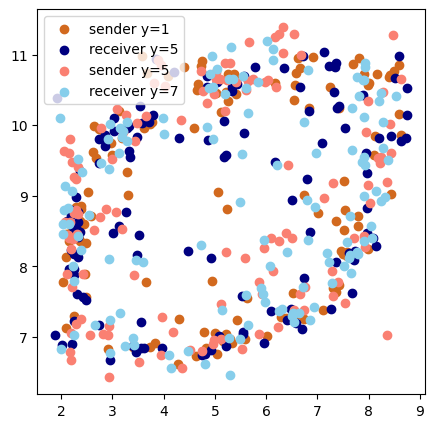

In [57]:
ig, ax = plt.subplots(figsize=(5, 5))
red_colors = ["red", "darkred", "salmon", "chocolate"]
blue_colors = ["blue", "skyblue", "navy"]
for i in range(10):
    # plot receiver with bluish color and sender with reddish color
    if len(receiver_y[receiver_y == i]) > 0:
        ax.scatter(reducer.transform(receiver_x[receiver_y == i])[:, 0],
                   reducer.transform(receiver_x[receiver_y == i])[:, 1],
                   label=f"receiver y={i}", color=blue_colors.pop())
    if len(sender_y[sender_y == i]) > 0:
        ax.scatter(reducer.transform(sender_x[sender_y == i])[:, 0],
                   reducer.transform(sender_x[sender_y == i])[:, 1],
                   label=f"sender y={i}", color=red_colors.pop())
ax.legend();

In [58]:
import sklearn.neighbors
# outlier_scores[outlier_scores == -1]
clf = sklearn.neighbors.LocalOutlierFactor(contamination='auto', novelty=True,)
# fit on receiver and predict on sender
clf.fit(reducer.transform(receiver_x))
outlier_scores = clf.predict(reducer.transform(sender_x))

In [59]:
sender_y[outlier_scores == -1]

tensor([5, 1, 1, 1, 1])